<a href="https://colab.research.google.com/github/osnow/AR_mutant_response/blob/master/AR_mut_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
#from sklearn.pipeline import Pipeline
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Import Dataset

In [ ]:
fingerprints = pd.read_csv('/content/drive/My Drive/2019-McGill-Mutants/features/Morg_FPs.csv',index_col=0)
#fingerprints = fingerprints.loc[:, fingerprints.var() != 0.0] #remove zero variance columns

zscales = pd.read_csv('/content/drive/My Drive/2019-McGill-Mutants/features/zscale.csv',header=None)
zscales = zscales.iloc[:,1:]
#zscales = zscales.loc[:, zscales.var() != 0.0] #remove zero variance columns

classes = pd.read_csv('/content/drive/My Drive/2019-McGill-Mutants/features/all_muts_classes_updated.csv', index_col=0)
zscales.index = classes.name

merged = fingerprints.merge(zscales,left_index=True,right_index=True)
print(merged.shape)


(282, 4148)


In [ ]:
merged.values[:5,2048:].shape

(5, 2100)

In [ ]:

ODM_data = pd.read_csv('/content/drive/My Drive/2019-McGill-Mutants/features/ODM_mutants_train.csv',index_col=0)
ODM_classes = ODM_data.pop('class')

ODM_data.columns = merged.columns
print(ODM_data.shape)

X = pd.concat([merged, ODM_data])
print(X.shape)

y = pd.concat([classes['class'], ODM_classes])
print(y.shape)
dummy_y = np_utils.to_categorical(y)

(44, 4148)
(326, 4148)
(326,)


#Make table of training data table for supplementary

In [ ]:
classes.reset_index(drop=True, inplace=True)

In [ ]:
df = pd.DataFrame(np.nan, index=range(0,100), columns=['Mutant','Bicalutamide','Flutamide','Enzalutamide','Apalutamide','VPC13566','VPC13789','Darolutamide','DHT'])
df

In [ ]:
classes['drug'] = [drug[-1] for drug in classes['name'].str.split('_')]

In [ ]:
classes['mutant'] = ['_'.join(mut[0:-1]) for mut in classes['name'].str.split('_')]


In [ ]:
classes

In [ ]:
pivoted = classes.pivot_table(values='class', index='mutant', columns='drug', aggfunc='first')
pivoted.index = pivoted.index.str.upper()
pivoted.to_csv('mutantsxdrugs.csv')

# Make ODM mutant validation set

In [ ]:
# create odm mutant zscales from the bica mutants
odm_zscales = zscales.iloc[:45,:].drop('wt_bic')
# change index name 
odm_zscales.index = odm_zscales.index.str.split('_').str[0]+'_odm'
odm_zscales.shape

(44, 2100)

In [ ]:
#creat matrix of only odm fingerprints 
odm_fp = fingerprints.loc['d880e_odm',:].values
fps = pd.DataFrame([odm_fp]*44)
# combine fps and zscales
odm_new_muts = np.hstack((fps,odm_zscales))
# convert to DF with names as index
odm_new_muts = pd.DataFrame(data=odm_new_muts,index=odm_zscales.index) 
odm_new_muts['class'] = odm_truth['Ground truth'].values # add classes column

In [ ]:
odm_new_muts.to_csv('/content/drive/My Drive/2019-McGill-Mutants/ODM_mutants_train.csv')

#Build NN model

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons1=128, neurons2=32, epochs=100,dropout1=0.1,dropout2=0.1,mbs=16):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=X.shape[1], kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(dropout1))
    model.add(Dense(neurons2, kernel_initializer='he_normal', activation='relu'))
    model.add(Dropout(dropout2))
    model.add(Dense(4, kernel_initializer='he_normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Column Transformer and over sample 

In [ ]:
from pickle import dump
scaler = StandardScaler()
scaler.fit(X_train_res[:,2048:])
dump(scaler, open('/content/drive/My Drive/2019-McGill-Mutants/scaler.pkl','wb'))

In [ ]:
X_train_res[:,2048:].shape

(764, 2100)

In [ ]:
from sklearn.compose import make_column_transformer 

ct = make_column_transformer(
        (StandardScaler(), slice(2048,4148)) # make sure this shape matches zscales
    ,remainder='drop',verbose=True)

BSmote = BorderlineSMOTE()

# Run Random CV pipeline

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
estimators = []
estimators.append(('standardize', ct))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, verbose=0)))
pipeline = Pipeline(estimators)
# define the grid search parameters
neurons1 = [256, 128, 64, 32]
neurons2 = [32, 16, 8]
epochs = [10, 20, 50, 100, 150]
mbs = [8, 16, 32, 64]
dropout1 = [0.0, 0.01, 0.1, 0.2, 0.3]
dropout2 = [0.0, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(mlp__neurons1=neurons1, mlp__neurons2=neurons2,mlp__epochs=epochs,mlp__dropout1=dropout1,mlp__dropout2=dropout2,mlp__mbs=mbs,mlp__class_weight=[class_weight,'auto'])
search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_jobs=1, cv=5, n_iter=25)
search_result = search.fit(X, dummy_y)
# summarize results
print("Best: %f using %s" % (search_result.best_score_, search_result.best_params_))
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# CV pipeline with plotted curves

In [ ]:
ls_mb_size = [8, 16, 32, 64]
ls_epoch = [10, 20, 50, 100, 150]
ls_rate = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3]
ls_h_dim1 = [256, 128, 64, 32]
ls_h_dim2 = [64, 32, 16, 8]
acts = ['relu', 'elu']

max_iter = 25
save_results_to = './val_curves/'

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for iters in range(max_iter):
    
    mbs = np.random.choice(ls_mb_size)
    hdm1 = np.random.choice(ls_h_dim1)
    hdm2 = np.random.choice(ls_h_dim2)
    epoch = np.random.choice(ls_epoch)
    rate1 = np.random.choice(ls_rate)
    rate2 = np.random.choice(ls_rate) 
    act = np.random.choice(acts)

    k = 0

    for tr_ind, ts_ind in kf.split(X.values):
        k = k + 1

        ct.fit(X.values[tr_ind,:])
        X_train_trans = ct.transform(X.values[tr_ind,:])
        X_test_trans = ct.transform(X.values[ts_ind,:])
        X_train = np.hstack((X.values[tr_ind,:210],X_train_trans))
        X_test = np.hstack((X.values[ts_ind,:210],X_test_trans))
        
        X_train, y_train = BorderlineSMOTE().fit_resample(X_train, dummy_y[tr_ind,:])

        model = Sequential()
        model.add(Dense(hdm1, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation=act))
        model.add(Dropout(rate1))
        model.add(Dense(hdm2, kernel_initializer='he_normal', activation=act))
        model.add(Dropout(rate2))
        model.add(Dense(4, kernel_initializer='he_normal', activation='softmax'))
        #model.summary()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=mbs,  verbose=0, validation_data=(X_test,dummy_y[ts_ind,:]))
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        title2 = 'Loss Train iter = {}, fold = {}, mb_size = {},  epoch = {}, rate = ({},{}), dim = ({},{}), act = {}'.\
                          format(iters, k, mbs, epoch, rate1, rate2, hdm1, hdm2, act)
        plt.title(title2)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(save_results_to + title2 + '.png', dpi = 150, bbox_inches = 'tight')
        plt.close()
    K.clear_session()

#Retrain with best params and predict

In [ ]:
X_train = X.loc[~X.index.str.contains('odm'),:]
X_test = X.loc[X.index.str.contains('odm'),:]
y_train = dummy_y[~X.index.str.contains('odm'),:]
y_test = dummy_y[X.index.str.contains('odm'),:]


In [ ]:
# Train on whole dataset (no split)
X_train, y_train = X, dummy_y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y, test_size=0.2, random_state=42)


In [ ]:
X_train_res, y_train_res = BorderlineSMOTE().fit_resample(X_train, y_train)
#X_train_res, y_train_res = X_train, y_train

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
X_train_trans = ct.fit_transform(X_train_res)
#X_test_trans = ct.transform(X_test)
X_train = np.hstack((X_train_res[:,:2048],X_train_trans))
#X_test = np.hstack((X_test.iloc[:,:210],X_test_trans))

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


In [ ]:
X_train.shape

(720, 4148)

In [ ]:
# model callbacks 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
mc = ModelCheckpoint(filepath='/content/drive/My Drive/2019-McGill-Mutants/best_model_new.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

In [ ]:
# create and fit on train data using best hyperparameters 
model = create_model(neurons1=128,neurons2=32,epochs=50, dropout1=0.01,dropout2=0.01, mbs=32)
model.fit(X_train,y_train_res,verbose=1,epochs=100,batch_size=16,validation_split=0.2, callbacks=[early_stopping,mc])

Train on 576 samples, validate on 144 samples
Epoch 1/100
576/576 [==============================] - 1s 1ms/step - loss: 1.2289 - accuracy: 0.4688 - val_loss: 1.0194 - val_accuracy: 0.4931

Epoch 00001: val_accuracy improved from -inf to 0.49306, saving model to /content/drive/My Drive/2019-McGill-Mutants/best_model_new.h5
Epoch 2/100
576/576 [==============================] - 0s 529us/step - loss: 0.6734 - accuracy: 0.7674 - val_loss: 1.5941 - val_accuracy: 0.3472

Epoch 00002: val_accuracy did not improve from 0.49306
Epoch 3/100
576/576 [==============================] - 0s 446us/step - loss: 0.4933 - accuracy: 0.8438 - val_loss: 0.6532 - val_accuracy: 0.7083

Epoch 00003: val_accuracy improved from 0.49306 to 0.70833, saving model to /content/drive/My Drive/2019-McGill-Mutants/best_model_new.h5
Epoch 4/100
576/576 [==============================] - 0s 470us/step - loss: 0.4209 - accuracy: 0.8594 - val_loss: 0.8102 - val_accuracy: 0.5069

Epoch 00004: val_accuracy did not improve fr

In [ ]:
# RF baseline Train and test 
random_state = np.random.RandomState(0)
model = RandomForestClassifier(n_estimators=50,max_depth=10, random_state=random_state,verbose=0,n_jobs=-1)
model.fit(X_train,y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False,
                       random_state=RandomState(MT19937) at 0x7FAF8A983888,
                       verbose=0, warm_start=False)

In [ ]:
# SVM baseline Train and Test
model = OneVsRestClassifier(svm.SVC(kernel='rbf', C= 100, gamma = .001, probability=True,
                                 random_state=random_state))
model.fit(X_train,y_train_res)

OneVsRestClassifier(estimator=SVC(C=100, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.001, kernel='rbf', max_iter=-1,
                                  probability=True,
                                  random_state=RandomState(MT19937) at 0x7FAF8A983888,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

# ODM predictions

In [ ]:
# compare preds to ground truth
odm_truth = pd.read_csv('/content/drive/My Drive/2019-McGill-Mutants/ODM_predictions.csv')
y_true = odm_truth['Ground truth']
y_pred = odm_truth['Predicted']

report = classification_report(y_true, y_pred, output_dict=True,zero_division=0)
print("Test Report", report)
cr = pd.DataFrame(report).transpose()
cr

Test Report {'0': {'precision': 1.0, 'recall': 0.9230769230769231, 'f1-score': 0.9600000000000001, 'support': 13}, '1': {'precision': 0.967741935483871, 'recall': 0.967741935483871, 'f1-score': 0.967741935483871, 'support': 31}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.9545454545454546, 'macro avg': {'precision': 0.6559139784946236, 'recall': 0.6302729528535981, 'f1-score': 0.6425806451612903, 'support': 44}, 'weighted avg': {'precision': 0.9772727272727273, 'recall': 0.9545454545454546, 'f1-score': 0.9654545454545456, 'support': 44}}


,precision,recall,f1-score,support
0,1.000000,0.923077,0.960000,13.000000
1,0.967742,0.967742,0.967742,31.000000
3,0.000000,0.000000,0.000000,0.000000
accuracy,0.954545,0.954545,0.954545,0.954545
macro avg,0.655914,0.630273,0.642581,44.000000
weighted avg,0.977273,0.954545,0.965455,44.000000


In [ ]:
# predict on ODM external validation set 
saved_model = load_model('best_model.h5')
odm_pred = saved_model.predict(X_test)
pred_classes = np.argmax(odm_pred, axis=1)
odm_pred_classes = pd.DataFrame(pred_classes,index=odm_zscales.index)
#odm_pred_classes.to_csv('/content/drive/My Drive/2019-McGill-Mutants/ODM_predictions.csv')



# Evaluate model and produce results

In [ ]:
# Train and test accuracy 
model = load_model('best_model.h5')
_, train_acc = model.evaluate(X_train, y_train_res, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.984, Test: 0.772


In [ ]:
# get results and report
y_pred_train = model.predict_proba(X_train)
y_pred_test = model.predict_proba(X_test)

# report accuracy
y_pred = np.argmax(y_pred_test, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, output_dict=True)
print("Test Report", report)
cr = pd.DataFrame(report).transpose()
cr.to_csv('DNN_class_report.csv')
cr

Test Report {'0': {'precision': 1.0, 'recall': 0.8571428571428571, 'f1-score': 0.923076923076923, 'support': 7}, '1': {'precision': 0.9032258064516129, 'recall': 0.8484848484848485, 'f1-score': 0.875, 'support': 33}, '2': {'precision': 0.5, 'recall': 0.25, 'f1-score': 0.3333333333333333, 'support': 4}, '3': {'precision': 0.5, 'recall': 0.6923076923076923, 'f1-score': 0.5806451612903226, 'support': 13}, 'accuracy': 0.7719298245614035, 'macro avg': {'precision': 0.7258064516129032, 'recall': 0.6619838494838495, 'f1-score': 0.6780138544251447, 'support': 57}, 'weighted avg': {'precision': 0.7948500282965478, 'recall': 0.7719298245614035, 'f1-score': 0.7757589279236138, 'support': 57}}


,precision,recall,f1-score,support
0,1.000000,0.857143,0.923077,7.00000
1,0.903226,0.848485,0.875000,33.00000
2,0.500000,0.250000,0.333333,4.00000
3,0.500000,0.692308,0.580645,13.00000
accuracy,0.771930,0.771930,0.771930,0.77193
macro avg,0.725806,0.661984,0.678014,57.00000
weighted avg,0.794850,0.771930,0.775759,57.00000


In [ ]:
y_pred

array([0, 0, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 2, 1, 3, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1])

#Plot confusion matrix

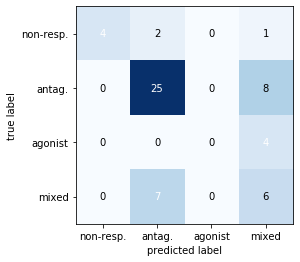

In [ ]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_target=y_true, 
                      y_predicted=y_pred, 
                      binary=False)


fig, ax = plot_confusion_matrix(conf_mat=cm)
ax.set_xticklabels(['','non-resp.','antag.', 'agonist', 'mixed'])
ax.set_yticklabels(['','non-resp.','antag.', 'agonist', 'mixed'])
plt.savefig('SVM_test_CM.eps',dpi=300)
plt.show()

# ROC curve with baselines

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 409 samples, validate on 103 samples
Epoch 1/100





409/409 [==============================] - 10s 24ms/step - loss: 1.8770 - acc: 0.3178 - val_loss: 1.5863 - val_acc: 0.3010
Epoch 2/100
409/409 [==============================] - 0s 151us/step - loss: 1.1709 - acc: 0.4841 - val_loss: 1.0340 - val_acc: 0.5437
Epoch 3/100
409/409 [==============================] - 0s 130us/step - loss: 0.9001 - acc: 0.6553 - val_loss: 1.1756 - val_acc: 0.3107
Epoch 4/100
409/409 [==============================] - 0s 133us/step - loss: 0.7326 - acc: 0.7702 - val_loss: 0.9886 - val_acc: 0.6019
Epoch 5/100
409/409 [==============================] - 0s 146us/step - loss: 0.5711 - acc: 0.8215 - val_loss: 0.6676 - val_acc: 0.7476
Epoch 6/100
409/409 [==============================] - 0s 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
Train on 416 samples, validate on 104 samples
Epoch 1/100
416/416 [==============================] - 0s 766us/step - loss: 1.7674 - acc: 0.3197 - val_loss: 1.3444 - val_acc: 0.2788
Epoch 2/100
416/416 [==============================] - 0s 130us/step - loss: 1.2106 - acc: 0.4591 - val_loss: 1.1712 - val_acc: 0.3558
Epoch 3/100
416/416 [==============================] - 0s 128us/step - loss: 1.0438 - acc: 0.5793 - val_loss: 1.0006 - val_acc: 0.3654
Epoch 4/100
416/416 [==============================] - 0s 132us/step - loss: 0.7937 - acc: 0.6827 - val_loss: 1.1181 - val_acc: 0.3846
Epoch 5/100
416/416 [==============================] - 0s 131us/step - loss: 0.6004 - acc: 0.7933 - val_loss: 0.8667 - val_acc: 0.7308
Epoch 6/100
416/416 [==============================] - 0s 135us/step - loss: 0.5415 - acc: 0.7861 - val_loss: 1.0447 - val_acc: 0.4615
Epoch 7/100
416/416 [==============================] - 0s 127us/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
Train on 416 samples, validate on 104 samples
Epoch 1/100
416/416 [==============================] - 0s 905us/step - loss: 1.6578 - acc: 0.3534 - val_loss: 2.0270 - val_acc: 0.2596
Epoch 2/100
416/416 [==============================] - 0s 138us/step - loss: 1.2658 - acc: 0.4327 - val_loss: 1.7461 - val_acc: 0.2019
Epoch 3/100
416/416 [==============================] - 0s 134us/step - loss: 0.9478 - acc: 0.6490 - val_loss: 1.4138 - val_acc: 0.2404
Epoch 4/100
416/416 [==============================] - 0s 128us/step - loss: 0.7472 - acc: 0.7548 - val_loss: 1.4049 - val_acc: 0.2596
Epoch 5/100
416/416 [==============================] - 0s 182us/step - loss: 0.6316 - acc: 0.7933 - val_loss: 2.0251 - val_acc: 0.2404
Epoch 6/100
416/416 [==============================] - 0s 157us/step - loss: 0.5318 - acc: 0.8197 - val_loss: 1.6716 - val_acc: 0.2500
Epoch 7/100
416/416 [==============================] - 0s 143us/step - lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
Train on 387 samples, validate on 97 samples
Epoch 1/100
387/387 [==============================] - 0s 1ms/step - loss: 1.8557 - acc: 0.3514 - val_loss: 1.7313 - val_acc: 0.0103
Epoch 2/100
387/387 [==============================] - 0s 154us/step - loss: 1.2815 - acc: 0.4755 - val_loss: 1.6742 - val_acc: 0.0103
Epoch 3/100
387/387 [==============================] - 0s 176us/step - loss: 1.0852 - acc: 0.5297 - val_loss: 1.5259 - val_acc: 0.1134
Epoch 4/100
387/387 [==============================] - 0s 168us/step - loss: 0.9454 - acc: 0.5633 - val_loss: 1.3452 - val_acc: 0.4124
Epoch 5/100
387/387 [==============================] - 0s 174us/step - loss: 0.8204 - acc: 0.6357 - val_loss: 1.4777 - val_acc: 0.2474
Epoch 6/100
387/387 [==============================] - 0s 151us/step - loss: 0.7698 - acc: 0.6873 - val_loss: 1.7301 - val_acc: 0.2371
Epoch 7/100
387/387 [==============================] - 0s 166us/step - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: Fu

[ColumnTransformer]  (1 of 1) Processing standardscaler, total=   0.0s
Train on 419 samples, validate on 105 samples
Epoch 1/100
419/419 [==============================] - 1s 1ms/step - loss: 1.5586 - acc: 0.3508 - val_loss: 2.2422 - val_acc: 0.2571
Epoch 2/100
419/419 [==============================] - 0s 164us/step - loss: 1.2111 - acc: 0.5084 - val_loss: 1.5850 - val_acc: 0.1524
Epoch 3/100
419/419 [==============================] - 0s 171us/step - loss: 1.0138 - acc: 0.6372 - val_loss: 1.1762 - val_acc: 0.3238
Epoch 4/100
419/419 [==============================] - 0s 173us/step - loss: 0.8568 - acc: 0.7064 - val_loss: 1.2289 - val_acc: 0.2952
Epoch 5/100
419/419 [==============================] - 0s 139us/step - loss: 0.6558 - acc: 0.7971 - val_loss: 1.3226 - val_acc: 0.3333
Epoch 6/100
419/419 [==============================] - 0s 153us/step - loss: 0.5857 - acc: 0.8043 - val_loss: 0.5805 - val_acc: 0.8571
Epoch 7/100
419/419 [==============================] - 0s 177us/step - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


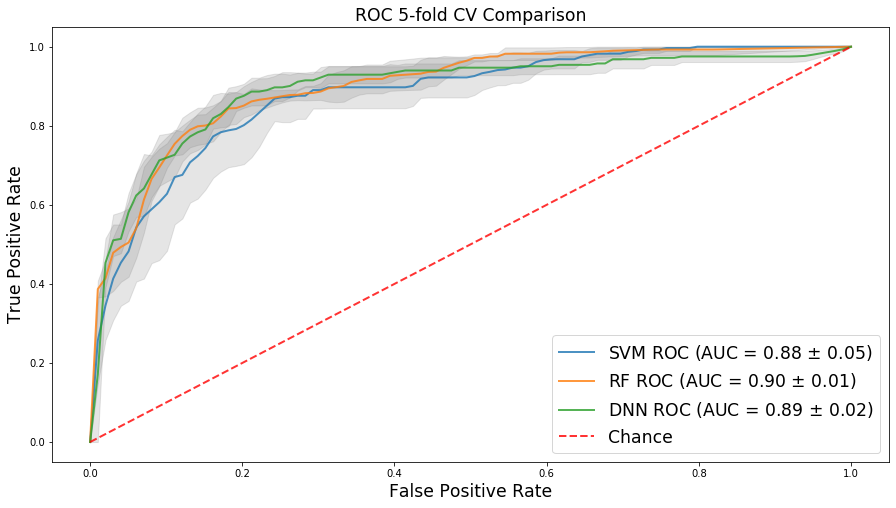

In [ ]:

fig = plt.figure(figsize=(15,8))
random_state = np.random.RandomState(0)

kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)


# Define baselines and NN 
svm_clf = OneVsRestClassifier(svm.SVC(kernel='rbf', C= 100, gamma = .001, probability=True,
                                 random_state=random_state))
rf_clf =  OneVsRestClassifier(RandomForestClassifier(n_estimators=50,max_depth=10, random_state=random_state,verbose=0,n_jobs=-1))
NN_clf = KerasClassifier(build_fn=create_model)

# DNN model callbacks 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
mc = ModelCheckpoint(filepath='./best_model.h5', monitor='val_acc', mode='auto', verbose=0, save_best_only=True)

names = ['SVM', 'RF', 'DNN']
classifiers = [svm_clf, rf_clf, NN_clf]

for i, classifier in enumerate(classifiers):
    tprs = []
    aucs = []

    fold = 0
    for train, test in kfold.split(X, dummy_y):
        X_train_res, y_train_res = BorderlineSMOTE().fit_resample(X.iloc[train,:], dummy_y[train,:])
        
        X_train_trans = ct.fit_transform(X_train_res)
        X_test_trans = ct.transform(X.iloc[test,:])
        X_train = np.hstack((X_train_res[:,:210],X_train_trans))
        X_test = np.hstack((X.iloc[test,:210],X_test_trans))

        if classifier == NN_clf:
            classifier.fit(X_train, y_train_res,callbacks=[early_stopping,mc],epochs=100,validation_split=0.2)
            #classifier = load_model('best_model.h5')
            probas_ = classifier.predict_proba(X_test)
        elif classifier == rf_clf:
            probas_ = classifier.fit(X_train, y_train_res).predict_proba(X_test)
        elif classifier == svm_clf:
            probas_ = classifier.fit(X_train, y_train_res).decision_function(X_test)   
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        #for i in range(4):
            #fpr[i], tpr[i], _ = roc_curve(y_train_res[test, i], probas_[:, i])
            #roc_auc[i] = roc_auc_score(y_train_res[test, i], probas_[:, i],average='weighted')

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(dummy_y[test].ravel(), probas_.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        roc_auc['micro'] = roc_auc_score(dummy_y[test], probas_,average='weighted')
        
        mean_fpr = np.linspace(0, 1, 100)

        # append to list and plot for each fold
        tprs.append(interp(mean_fpr, fpr['micro'], tpr['micro']))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc["micro"])
        #plt.plot(fpr['micro'], tpr['micro'], lw=2, alpha=0.3,
         #       label='ROC fold %d (AUC = %0.2f)' % (fold+1, roc_auc["micro"]))
        
        fold += 1

    mean_tpr_cv = np.mean(tprs, axis=0)
    mean_tpr_cv[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr_cv)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr_cv,
            label=r'%s ROC (AUC = %0.2f $\pm$ %0.2f)' % (names[i], mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr_cv + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr_cv - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
                    #,label=r'$\pm$ 1 std. dev.')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])


No handles with labels found to put in legend.


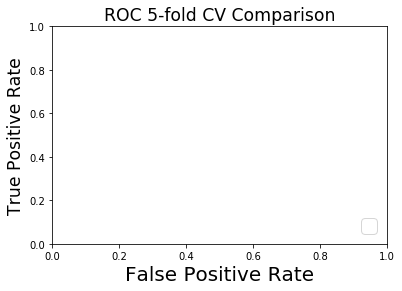

In [ ]:
plt.xlabel('False Positive Rate',fontsize='20')
plt.ylabel('True Positive Rate',fontsize='xx-large')
plt.title('ROC 5-fold CV Comparison', fontsize='xx-large')
plt.legend(loc="lower right",fontsize=20)
plt.savefig('ROC5fold_All_Oversampled_inloop.png',dpi=300)
plt.show()


'<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd9d40b0668>'